In [1]:
import sys
sys.path.append("../../eventepi")

import logging
import pickle
import warnings
from glob import glob

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
import tensorflow as tf

from gensim.models import KeyedVectors
from keras.models import load_model
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import  train_test_split

from eventepi.classification import DataLoader, Trainer, MeanDocumentEmbedder, EmbeddingNormalizer, TextNormalizer
tf.get_logger().setLevel(logging.ERROR)

In [2]:
paths = glob("data/results/relevance*.pickle") + ["data/results/CNN_model_softmax"]

In [3]:
def recall(y_true, y_pred):
    true_positives = keras.backend.sum(
        keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1))
    )
    possible_positives = keras.backend.sum(
        keras.backend.round(keras.backend.clip(y_true, 0, 1))
    )
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

In [4]:
X, y = DataLoader().labeled_texts()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13353)

In [5]:
embedder = MeanDocumentEmbedder()

X_embedded = np.array(list(embedder.transform(X)))
(X_train_embedded, X_test_embedded, y_train, y_test) = train_test_split(X_embedded, y, test_size=0.25, random_state=13353)

In [6]:
wv = KeyedVectors.load("data/embeddings/embeddings_300")
vocab = [i for i in wv.wv.vocab.keys()]

# Unknown vocabs are set to <UNK>.
encoder = dict(zip(['<UNK>'] + vocab, range(len(vocab) +1)))
decoder = dict(zip(encoder.values(), encoder.keys()))

pretrained_embedding = np.array([wv.wv[word] for word in vocab])
# Unknown vocabs will have embedding weights of zero.
embedding = np.zeros((pretrained_embedding.shape[0]+1, pretrained_embedding.shape[1]))
embedding[1:, :] = pretrained_embedding

In [7]:
MAX_SEQ_LENGTH = 400 # Calculated from where 63 words is the shortest found text
EMBEDDING_DIM = embedding.shape[1]

data_indices = np.array(range(len(X)))

train, validate, test = np.split(data_indices, [int(.6*len(X)), int(.8*len(X))], )

normalizer = EmbeddingNormalizer()
X_normalized = [normalizer.normalize(text) for text in X]
# Unknown vocabs will have embedding weights of zero.
embedding = np.zeros((pretrained_embedding.shape[0]+1, pretrained_embedding.shape[1]))
embedding[1:, :] = pretrained_embedding
def prepare_own_dataset(X_sub_set, y_sub_set):
    xd = np.zeros((len(X_sub_set), MAX_SEQ_LENGTH, EMBEDDING_DIM))
    y = y_sub_set

    articles = []
    for i, tokenized in enumerate(X_sub_set):
        article = []
        for j, v in enumerate(tokenized[:MAX_SEQ_LENGTH]):
            if v in encoder and ("promed" not in v) and ("who" not in v):
                e_idx = encoder[v]
            else:
                e_idx = 0

            xd[i, j, :] = embedding[e_idx]
            article.append(e_idx)
        articles.append(article)

    return dict(x4d=np.expand_dims(xd, axis=1), y=y, encoded_articles=articles)


DATASETS = dict()

DATASETS["training"] = prepare_own_dataset(
    np.array(X_normalized)[train], np.array(y)[train]
)
DATASETS["testing"] = prepare_own_dataset(
    np.array(X_normalized)[test], np.array(y)[test]
)
DATASETS["validation"] = prepare_own_dataset(
    np.array(X_normalized)[validate], np.array(y)[validate]
)

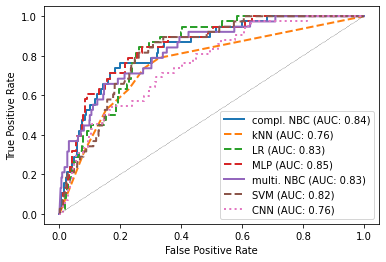

In [8]:
test_set = [X_test, X_test_embedded, X_test_embedded, X_test_embedded, X_test, X_test_embedded,  DATASETS["testing"]["x4d"]]
test_targets  = ([y_test] * 6) + [DATASETS["testing"]["y"]]
markers = ['-', '--', '--', '--', "-", "--", ":"]
names = ["compl. NBC", "kNN", "LR", "MLP", "multi. NBC", "SVM", "CNN"]
for i, path in enumerate(paths):
    if not "CNN" in path:
        with open(path, "rb") as f:
            clf = pickle.load(f)
        y_pred = clf.predict_proba(test_set[i])
    else:
        clf = load_model(path, custom_objects={"recall": recall})
        y_pred = clf.predict(test_set[i])
    fpr, tpr, thresholds = roc_curve(test_targets[i], y_pred[:,1])
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds}).to_csv(
        f"data/results/{names[i].replace('.', '').replace(' ', '_')}"
    )
    auc_score = auc(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     #plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot(fpr, 
             tpr, 
             linestyle=markers[i], 
             label=f"{names[i]} (AUC: {auc_score:.2f})",
             linewidth=2,
            )
    plt.legend(loc="best")
plt.plot([0,1], [0,1], linestyle=":", color="black",linewidth=0.5)
plt.savefig("data/results/roc_relevance_scoring.pdf")
plt.show()

In [9]:
X_date, y_date = DataLoader().labeled_date_sentences()
X_count, y_count = DataLoader().labeled_count_sentences()

Create labeled sentences: 100%|██████████| 112/112 [02:48<00:00,  1.51s/it]


In [10]:
X_train_date, X_test_date, y_train_date, y_test_date = train_test_split(X_date, y_date, 
                                                                        test_size=0.25, 
                                                                        random_state=13353,
                                                                        stratify=y_date,
                                                                       )
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count, 
                                                                            y_count, 
                                                                            test_size=0.25, 
                                                                            random_state=13353,
                                                                            stratify=y_count,
                                                                           )

In [11]:
paths = ["data/results/count_Bernoulli_model.pickle", 
         "data/results/count_multinomial_model.pickle", 
         "data/results/date_Bernoulli_model.pickle", 
         "data/results/date_multinomial_model.pickle"]

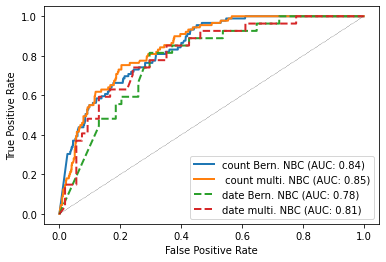

In [12]:
train_sets = [X_train_count, X_train_count, X_train_date, X_train_date]
train_targets  = [y_train_count, y_train_count, y_train_date, y_train_date]

test_sets = [X_test_count, X_test_count, X_test_date, X_test_date]
test_targets  = [y_test_count, y_test_count, y_test_date, y_test_date]

markers = ['-', '-', '--', '--']
names = ["count Bern. NBC", " count multi. NBC", "date Bern. NBC", "date multi. NBC"]

for i in range(len(paths)):
#     clf = models[i]
    with open(paths[i], "rb") as f:
        clf = pickle.load(f)
#     clf = clf.fit(train_sets[i], train_targets[i])
    y_pred = clf.predict_proba(test_sets[i])
    fpr, tpr, thresholds = roc_curve(test_targets[i], y_pred[:,1])
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds}).to_csv(
        f"data/results/roc_{names[i].replace('.', '').replace(' ', '_')}.csv"
    )
    auc_score = auc(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     #plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot(fpr, 
             tpr, 
             linestyle=markers[i], 
             label=f"{names[i]} (AUC: {auc_score:.2f})",
             linewidth=2,
            )
    plt.legend(loc="best")
    del clf
plt.plot([0,1], [0,1], linestyle=":", color="black",linewidth=0.5)
plt.savefig("data/results/roc_entity_extraction.pdf")
plt.show()